In [36]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from imblearn.over_sampling import (RandomOverSampler, SMOTE, BorderlineSMOTE)
from imblearn.under_sampling import (RandomUnderSampler, NearMiss, TomekLinks)
from sklearn.model_selection import GridSearchCV

pd.options.display.float_format = '{:,.3f}'.format

In [2]:
# read data
data = pd.read_csv('TravelInsurance2.csv', sep=';')
data.head()

,Age,Employment.Type,GraduateOrNot,AnnualIncome,FamilyMembers,ChronicDiseases,FrequentFlyer,EverTravelledAbroad,TravelInsurance
0,33,Private Sector/Self Employed,Yes,750000,7,1,No,No,1
1,29,Private Sector/Self Employed,Yes,1100000,2,0,No,No,0
2,31,Government Sector,Yes,1200000,3,0,No,No,0
3,26,Private Sector/Self Employed,Yes,500000,3,0,No,No,0
4,28,Private Sector/Self Employed,Yes,800000,3,0,No,No,0


In [3]:
mapping = {'Yes': 1,
          'No': 0,}

cols_to_map = ['GraduateOrNot', 'FrequentFlyer', 'EverTravelledAbroad']
for col in cols_to_map:
    data[col] = data[col].map(mapping)

In [4]:
print(f"Liczba danych: {len(data)}")
print(f"Liczba osob, ktore wykupily i nie wykupily ubezpieczenia: \n{data['TravelInsurance'].value_counts()}")

Liczba danych: 1000
Liczba osob, ktore wykupily i nie wykupily ubezpieczenia: 
0    659
1    341
Name: TravelInsurance, dtype: int64


## EDA

In [5]:
travelinsur1 = data[data['TravelInsurance'] == 1]
travelinsur0 = data[data['TravelInsurance'] == 0]

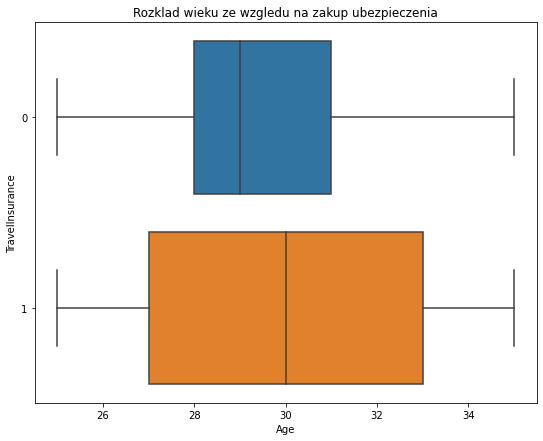

In [6]:
# Age
fig, ax = plt.subplots(figsize=(9,7))
sns.boxplot(data=data, x='Age', y='TravelInsurance', orient='h')
ax.set_title('Rozklad wieku ze wzgledu na zakup ubezpieczenia')
plt.show()

<AxesSubplot:xlabel='TravelInsurance'>

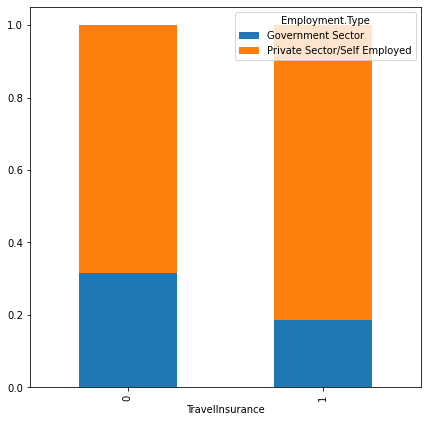

In [7]:
# Employment.Type
(data.groupby('TravelInsurance')['Employment.Type'].value_counts(normalize=True)
   .unstack('Employment.Type').plot.bar(stacked=True, figsize=(7,7))
)

<AxesSubplot:xlabel='TravelInsurance'>

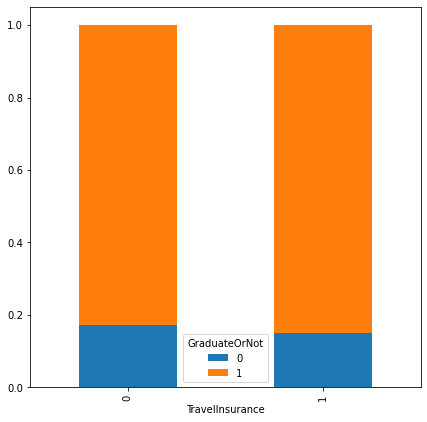

In [8]:
# GraduateOrNot
(data.groupby('TravelInsurance')['GraduateOrNot'].value_counts(normalize=True)
   .unstack('GraduateOrNot').plot.bar(stacked=True, figsize=(7,7))
)

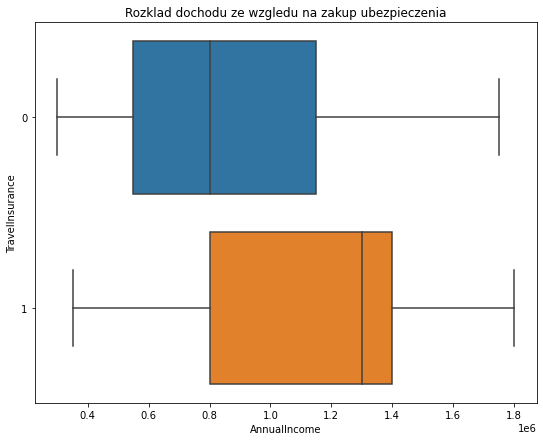

In [9]:
# AnnualIncome
fig, ax = plt.subplots(figsize=(9,7))
sns.boxplot(data=data, x='AnnualIncome', y='TravelInsurance', orient='h')
ax.set_title('Rozklad dochodu ze wzgledu na zakup ubezpieczenia')
plt.show()

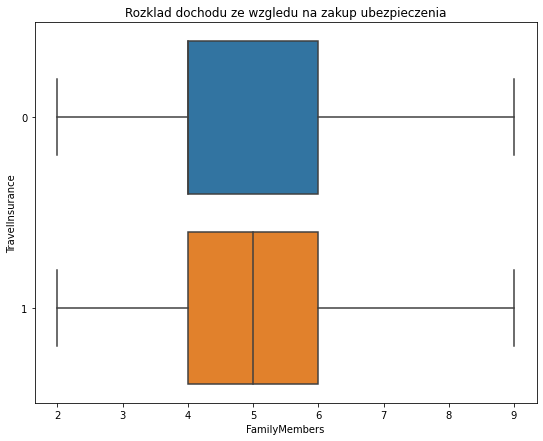

In [10]:
# FamilyMembers
fig, ax = plt.subplots(figsize=(9,7))
sns.boxplot(data=data, x='FamilyMembers', y='TravelInsurance', orient='h')
ax.set_title('Rozklad dochodu ze wzgledu na zakup ubezpieczenia')
plt.show()

In [11]:
fam_members_grouped = data.groupby('TravelInsurance')['FamilyMembers'].value_counts(normalize=True)
fam_members_grouped = fam_members_grouped.reset_index(name='Percentage')

<AxesSubplot:xlabel='FamilyMembers', ylabel='Percentage'>

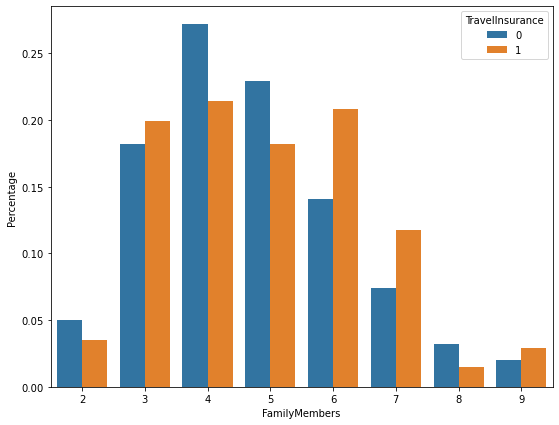

In [12]:
fig, ax = plt.subplots(figsize=(9, 7))
sns.barplot(data=fam_members_grouped, x='FamilyMembers', y='Percentage', hue='TravelInsurance')

<AxesSubplot:xlabel='TravelInsurance'>

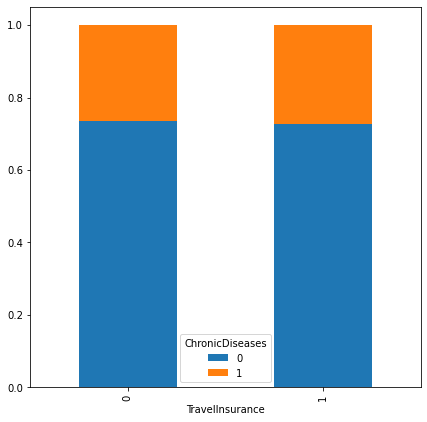

In [13]:
# ChronicDiseases
(data.groupby('TravelInsurance')['ChronicDiseases'].value_counts(normalize=True)
   .unstack('ChronicDiseases').plot.bar(stacked=True, figsize=(7,7))
)

<AxesSubplot:xlabel='TravelInsurance'>

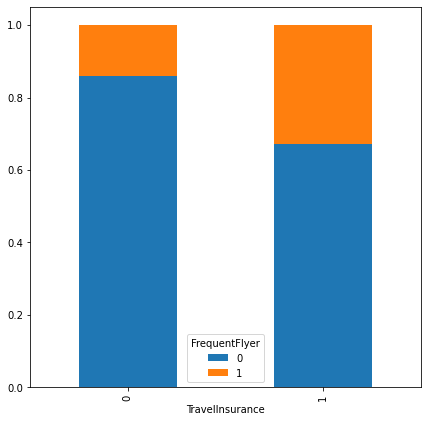

In [14]:
# FrequentFlyer
(data.groupby('TravelInsurance')['FrequentFlyer'].value_counts(normalize=True)
   .unstack('FrequentFlyer').plot.bar(stacked=True, figsize=(7,7))
)

<AxesSubplot:xlabel='TravelInsurance'>

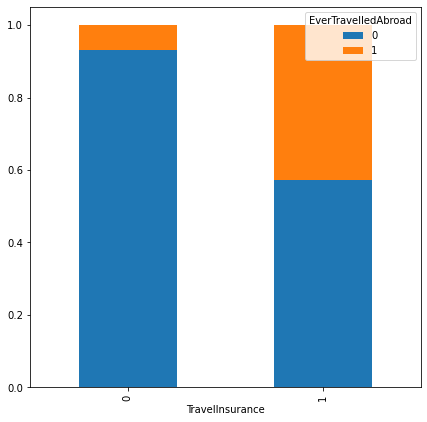

In [15]:
# EverTravelledAbroad
(data.groupby('TravelInsurance')['EverTravelledAbroad'].value_counts(normalize=True)
   .unstack('EverTravelledAbroad').plot.bar(stacked=True, figsize=(7,7))
)

## Przygotowanie zmiennych

In [16]:
# relevant features
relevant_features = [
    'Age',
    'Employment.Type',
    'AnnualIncome',
    'FamilyMembers',
    'FrequentFlyer',
    'EverTravelledAbroad',
    'TravelInsurance',
]

data = data[relevant_features]

In [17]:
data['Employment.Type'] = data['Employment.Type'].map({
    'Private Sector/Self Employed': 1,
    'Government Sector': 0
})

In [18]:
data.head()

,Age,Employment.Type,AnnualIncome,FamilyMembers,FrequentFlyer,EverTravelledAbroad,TravelInsurance
0,33,1,750000,7,0,0,1
1,29,1,1100000,2,0,0,0
2,31,0,1200000,3,0,0,0
3,26,1,500000,3,0,0,0
4,28,1,800000,3,0,0,0


In [21]:
# podzial na zbior uczacy i testowy
X = data.drop('TravelInsurance', axis=1)
y = data['TravelInsurance']

X_train, X_test, y_train, y_test = train_test_split(X, y, train_size=0.2, random_state=42)

In [26]:
# skalowanie danych
scaler = MinMaxScaler()
X_train = pd.DataFrame(scaler.fit_transform(X_train))
X_train.columns = X.columns
X_test = pd.DataFrame(scaler.fit_transform(X_test))
X_train.columns = X.columns

## Tworzenie modeli

In [31]:
sampling_methods = [
    None,
    RandomOverSampler(random_state=42),
    SMOTE(random_state=42),
    BorderlineSMOTE(random_state=42),
    RandomUnderSampler(random_state=42),
    NearMiss(version=3),
    TomekLinks()
]

In [38]:
# KNeighborsClassifier
for sampler in sampling_methods:
    if sampler==None:
        X_train_res, y_train_res = X_train.copy(), y_train.copy()
    else:
        X_train_res, y_train_res = sampler.fit_resample(X_train, y_train)
        
        grid_param = {
            'n_neighbors': [3, 5, 7, 10, 15],
            'algorithm': ['auto', 'ball_tree', 'kd_tree', 'brute',],
            'metric': ['cosine', 'euclidean', 'l1', 'l2', 'manhattan'],
        }
        
        clf = KNeighborsClassifier()
        GridSearchCV(estimator=clf, param_grid=grid_param, cv=5)